# Predictive Analytical Methods in Finance

## Project 1

### Official tasks:
- Make a preliminary statistical analysis of the credit dataset. DONE, 'TASK 1'.
- Develop a logistic regression model. DONE, 'TASK 2'.
- Develop a machine learning model. DONE, 'TASK 3'.
- Develop a deep learning model. DONE, 'TASK 4'.
- Evaluate the models results (predictive power). Working on, 'TASK 5'.

In [1]:
# ------ Functions, Options and General Imports
# I'll clean up the functions as I go
import warnings
import pandas as pd
#from pandas.tseries.offsets import DateOffset
import numpy as np

# General options setting
pd.set_option('display.max_rows', 250)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True, precision=4)

# ------ Functions

# Function to fetch the definition of each feature and to analyze NaNs
def general_analysis(lista, dataframe: pd.DataFrame):
    import pandas as pd
    """
    :param lista: lista de features a se verificar
    :dtype lista: list
    :param dataframe: o banco de dados que contem todas as features que serão verificadas
    :type dataframe: DataFrame
    """
    def significado(x: object):
        dic = pd.read_csv('./data/dictionary.csv', index_col=False)
        print(f'Feature Name: {str(x).upper()}')
        print(f'Definition: {dic[dic['Feature'] == str(x)]['Descrição'].values}')

    if len(lista) > 1:
        for i in range(0, len(lista)):
            print('\n')
            print(f'Feature #{i+1}/{len(lista)}')
            significado(lista[i])
            print(f'Data type: {str(dataframe[lista[i]].dtypes).upper()}')
            print(f'Total NaNs: {dataframe[lista[i]].isnull().sum()}')
            print(f'NaN proportion: {round((dataframe[lista[i]].isnull().sum()/len(dataframe))*100, 2)}%')
    elif len(lista) == 1:
        print('\n')
        significado(lista[0])
        print(f'Data type: {str(dataframe[lista[0]].dtypes).upper()}')
        print(f'Total NaNs: {dataframe[lista[0]].isnull().sum()}')
        print(f'NaN proportion: {round((dataframe[lista[0]].isnull().sum()/len(dataframe))*100, 2)}%')


# Função para armazenar os valores de média e desvio padrão das features, para normalização dos valores
def standardize_it(df: pd.DataFrame, norm:list):
    import pandas as pd
    from scipy import stats
    """
    Args: df = DataFrame contendo os dados que serão utilizados
          norm = lista com a relação das features que precisam passar por normalização. Caso
                 norm=False a função utiliza as features do DataFrame original

    Returns: DataFrame contendo os valores de média e desvio padrão de cada feature; lista
            contendo o nome das features utilizadas
    """
    if norm:
        pass
    else:
    # Normalização apenas das colunas originais, sem contar as categóricas (como 'fez_hardship', por exemplo)
        norm = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'borrower_total_time']

    hist = {}
    for name in norm:
        media = df[name].mean()
        desvio = df[name].std()
        hist.update({name: {
                            'Mean': media,
                            'StDev': desvio,
                            }
    })

    try:
        print('Initiating standardization process.\n')
        standard_df = pd.DataFrame()
        for name in norm:
            standard_df[name] = stats.zscore(df[name])
        print('Standardization process ended successfully!')
    except Exception as e:
        print(f"Yeah... There's this error during standardization process: {e}. Please take a look.")
    
    return standard_df, hist


# Análise das métricas e geração da matriz de confusão
def showme_metrics(classif=None, X=pd.DataFrame, y=pd.Series, color='Oranges', target='target'):
    from timeit import default_timer as timer
    from sklearn import metrics
    import matplotlib.pyplot as plt
    import seaborn as sns
    from datetime import timedelta
    from sklearn.metrics import precision_score, recall_score, accuracy_score
    """
    Args:
    - classif: o algoritmo utilizado (o objeto que processa o .fit)
    - X: DataFrame (normalmente teste_x)
    - y: Series (normalmente teste_y)
    - color: Seaborn color pallete
    - target: variável dependente (o 'y')

    Returns:
    - dict: metrics observed
    """
    if not classif:
        print('The model must be trained beforehand. Please do so.')
    else:
        # ------ Cálculo das métricas do modelo
        print('Predicting values and estimating evaluation metrics.\n')
        inicio_prev = timer()
        ypred = classif.predict(X).astype(int)  # previsão dos dados de teste, astype garante que o output não seja float (caso do TF)
        acc = accuracy_score(y, ypred)  # cálculo accuracy (eficiência geral do modelo)
        sens = recall_score(y, ypred, pos_label=1)  # cálculo da sensitividade/recall (taxa de acerto dos eventos)
        spec = recall_score(y, ypred, pos_label=0)  # cálculo da especificidade (taxa de acerto dos não-eventos)
        prec = precision_score(y, ypred)  # taxa de acerto dos positivos totais (TP/(TP+FP))
        fim_prev = timer()

        print(f'Model analytics:\n')
        print(f'Accuracy: {acc:.6f}')
        print(f'Sensitivity/Recall: {sens:.6f}')
        print(f'Specificity: {spec:.6f}')
        print(f'Precision: {prec:.6f}')
        print(f'Timelapse {timedelta(seconds=fim_prev-inicio_prev)}.')
        print('\n')


        # ------ Matriz de confusão
        conf_matrix = metrics.confusion_matrix(y[target].values.astype('int'), ypred, labels=[1, 0])
        plt.figure(figsize=(6, 6))
        sns.heatmap(conf_matrix,
                    fmt='d',
                    annot=True,
                    cmap=color,
                    xticklabels=['Default', 'Comply'],
                    yticklabels=['Default', 'Comply'])
        plt.title(f'Confusion Matrix', fontsize=12)
        plt.xlabel('Observed data', fontsize=12)
        plt.ylabel('Predicted data', fontsize=12)
        plt.show()

        return ypred, {'Model': str(classif), 'Accuracy': acc, 'Sensitivity': sens, 'Specificity':spec, 'Precision':prec}

In [2]:
# RUN THIS BOX JUST AT THE FIRST TIME! (don't need to run this again after the first time)
# DATASET JOINING
#=========================

# Loading train and test datasets*
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Adding two empty features to test dataset
test['loan_status'] = np.nan
test['target'] = np.nan

# Renaming the 'risk' feature to 'target', just because
train = train.rename(columns={'risk': 'target'})

# Adding a record for where the data comes from
train['origin'] = 'Train'
test['origin'] = 'Test'

# Joining them
complete = pd.concat([train, test])

# Export train, test and complete datasets to parquet format
train.to_parquet('./data/train.parquet', index=False)
test.to_parquet('./data/test.parquet', index=False)
complete.to_parquet('./data/complete.parquet', index=False)

# * the original (Moodle) datasets had issues when I downloaded them, some I adjusted with Excel, some I adjusted in Python

In [3]:
# DATA LOADING
#=========================

# Loading the complete dataset.
# NOTE: usually the data wrangling is done individually in either train/test datasets to avoid information leakage, but it won't happen here
print('Loading the original complete dataset...')
emprestimos = pd.read_parquet('./data/complete.parquet')
print('...done.\n')

Loading the original complete dataset...
...done.



## Task 1:
### Make a preliminary statistical analysis of the credit dataset

In [4]:
# STATISTICAL ANALYSIS
#=========================

print('The following tables describe the statistical analysis for both classes of features, namely numerical features and \ncategorical features, that were made available in the original (raw) dataset.\n')

# Filters for each type of data (numeric/categorical)
nums = emprestimos.dtypes != 'object'
objs = emprestimos.dtypes == 'object'

# Selects the numeric features and summons the statistical analysis
lista = emprestimos.dtypes[nums].index.to_list()
print('Statistical summary of the numerical features:\n')
print(emprestimos[lista].drop('id', axis=1).describe())

# The same for the categorical features
lista = emprestimos.dtypes[objs].index.to_list()
print('\nStatistical summary of the numerical features:\n')
print(emprestimos[lista].describe())


The following tables describe the statistical analysis for both classes of features, namely numerical features and 
categorical features, that were made available in the original (raw) dataset.

Statistical summary of the numerical features:

        loan_amnt  funded_amnt  funded_amnt_inv    int_rate  installment  \
count 331304.0000  331304.0000      331304.0000 331304.0000  331304.0000   
mean   15485.6705   15485.6705       15479.0312     12.5709     452.0909   
std     9182.7264    9182.7264        9181.2607      4.6853     264.2243   
min     1000.0000    1000.0000         725.0000      5.3200      14.7700   
25%     8100.0000    8100.0000        8100.0000      8.8100     259.2400   
50%    14000.0000   14000.0000       14000.0000     11.9900     387.1500   
75%    20700.0000   20700.0000       20675.0000     15.3100     602.3000   
max    40000.0000   40000.0000       40000.0000     30.9900    1618.2400   

        annual_inc         dti  delinq_2yrs  inq_last_6mths    open_acc 

## Wrangling:
### Procedures needed to prepare the data for the modelling

In [5]:
# DATA WRANGLING
#=========================

# FIXING 'TERM' FEATURE TO NUMERIC
#=========================
print('Fixing "term" feature to numeric...')
emprestimos['term'] = emprestimos['term'].replace({emprestimos.loc[0, 'term']: 36, emprestimos.loc[1, 'term']: 60})
print('Done.\n')

# DEALING WITH NaN VALUES
#=========================
# Checking for NaN values
nvm = ['target', 'loan_status']
print(f'Checking for NaN values... OBS: features {nvm} are NOT considered here!\n')
nulls = emprestimos.drop(nvm, axis=1).isnull().sum() > 0
if len(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls]) > 0:
    print(f'{len(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls])} features with NaNs found, this is their proportion to the whole dataset:')
    print(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls]/emprestimos.shape[0]*100)
    nan_feat = emprestimos.drop(nvm, axis=1).isnull().sum()[nulls].index.to_list()
    print("\nAlso I created a list called 'nan_feat' with these features names. You're welcome.")
    print(f'nan_feat = {nan_feat}\n')
    # Overview of the features to be filled
    print('Overview of the features that have any NaN values:')
    general_analysis(nan_feat, emprestimos)
else:
    print('Absolutely no NaN values found in the dataset. Congratulations.\n')


print('Filling some NaNs data:')
# 'emp_title' fillna('Unknown'), it's impossible to infer the borrower's job title
print('"emp_title" missing data...')
emprestimos['emp_title'] = emprestimos['emp_title'].fillna('Unknown')
print('...ok.')

# 'emp_length' fillna('Unknown'), also it's not possible to infer the borrower's employment duration
print('"emp_length" missing data and rewriting category...')
emprestimos['emp_length'] = emprestimos['emp_length'].fillna('Unknown')
year = '< 1 year'
mask = emprestimos.emp_length == year
emprestimos.loc[mask, 'emp_length'] = 'up_to_1year'
print('...ok.')

# 'inq_last_6mths' has just one NaN observation. Since it represents almost nothing and there is
# 58% of the whole dataset with value zero, I'm imputing zero.
print('"inq_last_6mths" missing data...')
emprestimos['inq_last_6mths'] = emprestimos['inq_last_6mths'].fillna(0)
print('...ok.')

# 'revol_util' kinda makes sense that if your balance is zero then your utilization would be also zero
print('"revo_util" missing data...')
mask = emprestimos.revol_bal == 0
emprestimos.loc[mask, 'revol_util']= emprestimos.loc[mask, 'revol_util'].fillna(0)

# After this step, let's assume revol_util being zero for all Fully Paid statuses
mask = emprestimos.revol_util.isnull()
temp = emprestimos.loc[mask, 'loan_status'] == 'Fully Paid'
emprestimos['revol_util'].iloc[temp.index] = emprestimos['revol_util'].iloc[temp.index].fillna(0)
print('...ok.')

# 'dti' is easy to compute the local dti, albeit potentially not being 100% true regarding the overall dti
# Some individuals paid back (way) more then the value funded, so I'm assuming dti 0 for those (only 67 out of over 330k obs).
print('"dti" missing data...')
mask = emprestimos.dti.isnull() # get the NaN positions
dtis = (emprestimos[mask].funded_amnt - emprestimos[mask].total_pymnt)*100/emprestimos[mask].annual_inc # (funded-paid)/income
mask_dti = dtis < 0 # fetch just the negative values...
dtis.loc[mask_dti] = 0 # ...and replaces by zero
emprestimos.loc[mask, 'dti'] = dtis # assign the values to the original dataset
print('...ok.\n')

# Check again for NaN values, just to be sure
nvm = ['target', 'loan_status']
print(f'Checking again for NaN values... OBS: features {nvm} are NOT considered here!\n')
nulls = emprestimos.drop(nvm, axis=1).isnull().sum() > 0
if len(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls]) > 0:
    print(f'{len(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls])} features with NaNs found, this is their proportion to the whole dataset:')
    print(emprestimos.drop(nvm, axis=1).isnull().sum()[nulls]/emprestimos.shape[0]*100)
    nan_feat = emprestimos.drop(nvm, axis=1).isnull().sum()[nulls].index.to_list()
    print("\nAlso I created a list called 'nan_feat' with these features names. You're welcome.")
    print(f'nan_feat = {nan_feat}\n')
    # Overview of the features to be filled
    print('Overview of the features that have any NaN values:')
    general_analysis(nan_feat, emprestimos)
else:
    print('Absolutely no NaN values found in the dataset. Congratulations.\n')


# loan_status VS target FEATURES
#=========================
# If the status is Fully Paid, then the target must be zero, otherwise must be one
statuses = emprestimos.loan_status.value_counts().index.to_list()
print('Fixing the NaN values regarding the loan_status vs target features...')
for status in statuses:
    mask = (emprestimos.loan_status == status)
    if status == 'Fully Paid':
        print(f'Checking status {status}:')
        qty = emprestimos.loc[mask, 'target'].isnull().sum()
        print(f'Quantity of NaNs in target: {qty}')
        if qty > 0:
            print('Attribuing value 0 for the observation(s)...')
            emprestimos.loc[mask, 'target'] = 0
            print('Done.\n')
        elif qty == 0:
            print('Nothing to do.\n')
        else:
            print('PANIC!!! THIS IS NOT SUPPOSED TO HAPPEN!!!')
    else:
        print(f'Checking status {status}:')
        qty = emprestimos.loc[mask, 'target'].isnull().sum()
        print(f'Quantity of NaNs in target: {qty}')
        if qty > 0:
            print('Attribuing value 1 for the observation(s)...')
            emprestimos.loc[mask, 'target'] = 1
            print('Done.\n')
        elif qty == 0:
            print('Nothing to do.\n')
        else:
            print('PANIC!!! THIS IS NOT SUPPOSED TO HAPPEN!!!')


# FEATURE ENGENEERING: NEW FEATURE FROM issue_d AND earliest_cr_line
#=========================
print('Doing some feature engeneering now...')
# Re-set the appropriate features from obj to date
emprestimos['issue_d']= pd.to_datetime(emprestimos['issue_d'], format='%b-%y')
emprestimos['earliest_cr_line']= pd.to_datetime(emprestimos['earliest_cr_line'], format='%b-%y')

# Creates a new feature that considers the borrower's total experience time with 
# lending operations 
anos = (emprestimos['issue_d'].dt.year - emprestimos['earliest_cr_line'].dt.year)*12
meses = emprestimos['issue_d'].dt.month - emprestimos['earliest_cr_line'].dt.month
tempo_tomador = anos + meses
emprestimos['borrower_total_time'] = tempo_tomador
print('...done. You may proceed to the cleaning part.')

Fixing "term" feature to numeric...
Done.

Checking for NaN values... OBS: features ['target', 'loan_status'] are NOT considered here!

5 features with NaNs found, this is their proportion to the whole dataset:
emp_title        9.2936
emp_length       7.1913
dti              0.0501
inq_last_6mths   0.0003
revol_util       0.0694
dtype: float64

Also I created a list called 'nan_feat' with these features names. You're welcome.
nan_feat = ['emp_title', 'emp_length', 'dti', 'inq_last_6mths', 'revol_util']

Overview of the features that have any NaN values:


Feature #1/5
Feature Name: EMP_TITLE
Definition: ['Position reported by the borrower at the time of loan application']
Data type: OBJECT
Total NaNs: 30790
NaN proportion: 9.29%


Feature #2/5
Feature Name: EMP_LENGTH
Definition: ['Length of employment in years. Possible values between 0 and 10, with 0 being less than one year and 10 referring to ten years or more']
Data type: OBJECT
Total NaNs: 23825
NaN proportion: 7.19%


Feature #3

In [6]:
# CLEANING AND SPLITTING BACK TRAIN/TEST
#=========================
# Importing important stuff
from sklearn.preprocessing import OneHotEncoder

# I need to store a train/test index, in order not to get lost with those infos
print('Indexing both train and test observations...')
idx_train = emprestimos.origin == 'Train'
idx_test = emprestimos.origin == 'Test'
print('...done.\n')

# I'm in doubt if it's useful to keep 'addr_state' in the dataset, because it will be another 49 dummies at the final dataset.
print("Getting rid of features that won't be used...")
dropar = ['id', 'emp_title', 'issue_d', 'earliest_cr_line', 'loan_status', 'origin']
emprestimos.drop(dropar, axis=1, inplace=True)
print('...done.\n')

# Let's select just the 'object' type of data to perform one hot encoding, writing them in a list
print('Beginning one-hot-encoding process.')
objs = emprestimos.dtypes == 'object'
obj_list = emprestimos.dtypes[objs].index.to_list()

# Then create the encoder itself
ohe = OneHotEncoder(drop='first',
                    sparse_output=False).set_output(transform='pandas')

# Let the encoder do its job
emprestimos_ohe = ohe.fit_transform(emprestimos[obj_list])

# And we concatenate the numeric features from the previous dataset with this one-hot-encoded new dataset
emprestimos = pd.concat([emprestimos.drop(obj_list, axis=1), emprestimos_ohe], axis=1)
del emprestimos_ohe # memory management
print('One-hot-encoding done, datasets concatenated and memory freed.')

# Finally, with all wrangling done, let's split back train and test datasets
print('Splitting train/test datasets back to their original form and saving all new datasets on disk...')
train = emprestimos[idx_train]
test = emprestimos[idx_test].drop('target', axis=1)

# And just to be sure, write the new datasets on disk
emprestimos.to_parquet('./data/complete_wrangled.parquet')
train.to_parquet('./data/train_wrangled.parquet')
test.to_parquet('./data/test_wrangled.parquet')
print('Everything done. You can proceed to the modelling part.')

Indexing both train and test observations...
...done.

Getting rid of features that won't be used...
...done.

Beginning one-hot-encoding process.
One-hot-encoding done, datasets concatenated and memory freed.
Splitting train/test datasets back to their original form and saving all new datasets on disk...
Everything done. You can proceed to the modelling part.


In [7]:
# DATA READY FROM HERE
#=========================
emprestimos = pd.read_parquet('./data/complete_wrangled.parquet')
train = pd.read_parquet('./data/train_wrangled.parquet').reset_index(drop=True) # no idea why index turned out weird, also it doesn't matter
test = pd.read_parquet('./data/test_wrangled.parquet').reset_index(drop=True) # no idea why index turned out weird, also it doesn't matter

In [8]:
# PREPARING DATA TO MODELLING: VALIDATION, TRAIN AND TEST SPLITS
#=========================
import datetime
from datetime import timedelta
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split

# Splitting the train data into train/test set, and I'm splitting a validation dataset (10% of the observations) also, just to be sure
print('Storing 10% of the obs for validation...')
valid_size = 0.9
target = ['target']
test_data = train[target]
train_data = train.drop(target, axis = 1)
train_x, valid_x, train_y, valid_y = train_test_split(train_data, test_data, train_size=valid_size, random_state=1)

validation = pd.concat([valid_x, valid_y], axis=1)
train = pd.concat([train_x, train_y], axis=1)

print('Splitting remaining obs in train/test datasets.')
# Train dataset - train/test split, 80% of the remaining obs for training and the rest for testing
tamanho_treino = 0.8
treino_x, teste_x, treino_y, teste_y = train_test_split(train.drop(target, axis=1), train[target], train_size=tamanho_treino, random_state=1)

print('Standardizing the data now.')
treino_x, std_treino_x = standardize_it(treino_x, norm=False)
teste_x, std_teste_x = standardize_it(teste_x, norm=False)
valid_x, std_valid_x = standardize_it(valid_x, norm=False)

print('Training, testing and validation data standardized.')
print('All good!')

Storing 10% of the obs for validation...
Splitting remaining obs in train/test datasets.
Standardizing the data now.
Initiating standardization process.

Standardization process ended successfully!
Initiating standardization process.

Standardization process ended successfully!
Initiating standardization process.

Standardization process ended successfully!
Training, testing and validation data standardized.
All good!


## Task 2:
### Develop a logistic regression model

Beginning general timer and loading databases.
Establishing algorithm parameters.
Training the model...
Logistic Regression Model 20251216-1121 trained in 0:00:00.885724 total time.

============# Evaluation metrics using TEST dataset #============

Predicting values and estimating evaluation metrics.

Model analytics:

Accuracy: 0.783182
Sensitivity/Recall: 0.530680
Specificity: 0.909449
Precision: 0.745592
Timelapse 0:00:00.028785.




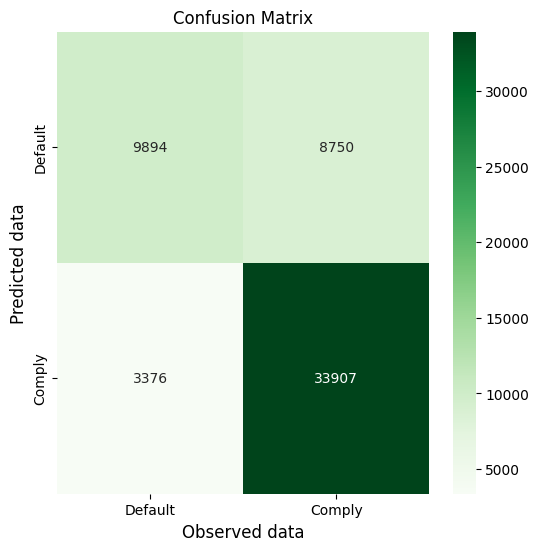

============# Evaluation metrics using VALIDATION dataset #============

Predicting values and estimating evaluation metrics.

Model analytics:

Accuracy: 0.783335
Sensitivity/Recall: 0.539480
Specificity: 0.907787
Precision: 0.749107
Timelapse 0:00:00.027958.




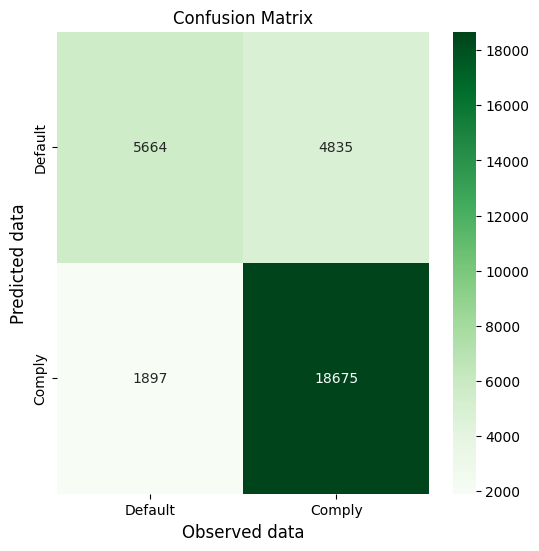

Logistic Regression Model 20251216-1121 training successfully completed with a total time of 0:00:01.575183.


In [9]:
#### MODEL 1. LOGISTIC REGRESSION
#### =========================
from sklearn.linear_model import LogisticRegression

try:
    print('Beginning general timer and loading databases.')
    inicio_geral = timer()

    # ------ Model parameters
    print('Establishing algorithm parameters.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_skl_lr = LogisticRegression(random_state=42,
                                        max_iter=1000)

    # ------ Model fitting
    print('Training the model...')
    inicio_treino = timer()
    classif_skl_lr.fit(treino_x, treino_y)
    fim_treino = timer()
    print(f'Logistic Regression Model {nome_modelo} trained in {timedelta(seconds=fim_treino-inicio_treino)} total time.\n')


    # ------ Model evaluation using test data
    print('============# Evaluation metrics using TEST dataset #============\n')
    graph_color = 'Greens'
    pred_lr, lr_test_dict = showme_metrics(classif=classif_skl_lr, X=teste_x, y=teste_y, color=graph_color, target=target)

    # ------ Model evaluation using validation data
    print('============# Evaluation metrics using VALIDATION dataset #============\n')
    _, lr_valid_dict = showme_metrics(classif=classif_skl_lr, X=valid_x, y=valid_y, color=graph_color, target=target)

    # ------ Training and results done
    fim_geral = timer()
    print(f'Logistic Regression Model {nome_modelo} training successfully completed with a total time of {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Some error occured during training: {e}! Please verify this.')


## Task 3:
### Develop a machine learning model

Beginning general timer and loading databases.
Establishing algorithm parameters.
Training the model...
Machine Learning (Boosting) Model 20251216-1121 trained in 0:00:21.741593 total time.

============# Evaluation metrics using TEST dataset #============

Predicting values and estimating evaluation metrics.

Model analytics:

Accuracy: 0.932877
Sensitivity/Recall: 0.878620
Specificity: 0.960009
Precision: 0.916573
Timelapse 0:00:00.140382.




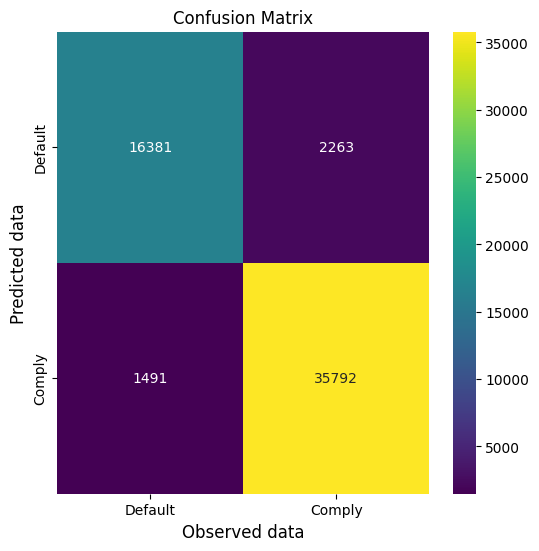

============# Evaluation metrics using VALIDATION dataset #============

Predicting values and estimating evaluation metrics.

Model analytics:

Accuracy: 0.889447
Sensitivity/Recall: 0.819888
Specificity: 0.924947
Precision: 0.847912
Timelapse 0:00:00.080816.




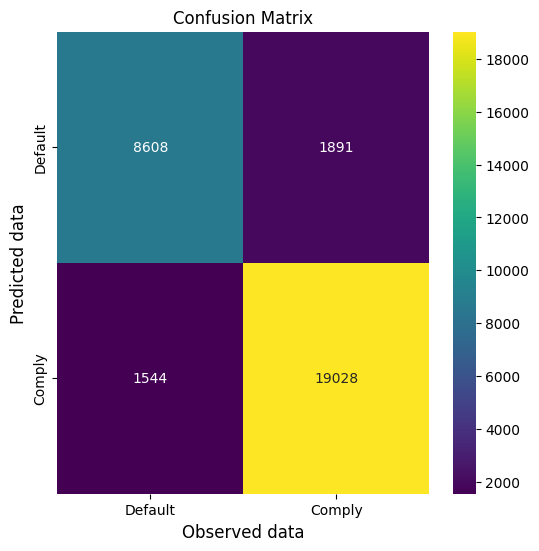

Machine Learning (Boosting) Model 20251216-1121 training successfully completed with a total time of 0:00:22.174637.


In [10]:
#### MODEL 2. MACHINE LEARNING - BOOSTING - CatBoost (CatBoostClassifier)
#### =========================
from catboost import CatBoostClassifier

try:
    print('Beginning general timer and loading databases.')
    inicio_geral = timer()

    # ------ Model parameters
    print('Establishing algorithm parameters.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_cat = CatBoostClassifier(loss_function='Logloss', # https://catboost.ai/en/docs/concepts/loss-functions-classification#usage-information
                                    eval_metric = 'Logloss', # Logloss, AUC, MAPE, Poisson, Precision, Accuracy, R2, MedianAbsoluteError, PairAccuracy, PrecisionAt https://catboost.ai/en/docs/references/custom-metric__supported-metrics
                                    iterations = 1000,
                                    learning_rate = 0.01,
                                    random_seed = 42,
                                    verbose = 0,
                                    bootstrap_type = 'MVS', #Bayesian (log), Bernoulli (stochastic), MVS (variance), Poisson (Poisson distribution)
                                    bagging_temperature = 7, 
                                    depth = 10,
                                    early_stopping_rounds = 500,
                                    thread_count = 12,
                                    task_type = 'CPU', 
                                    gpu_ram_part = 0.2,
                                    target_border = 0.5, 
                                    grow_policy = 'Lossguide', # Lossguide, Depthwise, SymmetricTree
                                    min_child_samples = 15, # default 1
                                    max_leaves = 20, # default 31
                                    boosting_type = 'Plain', # https://catboost.ai/en/docs/references/training-parameters/common#boosting_type
                                    score_function = 'L2' # L2, NewtonL2
                                    )


    # ------ Model fitting
    print('Training the model...')
    inicio_treino = timer()
    classif_cat.fit(treino_x, treino_y)
    fim_treino = timer()
    print(f'Machine Learning (Boosting) Model {nome_modelo} trained in {timedelta(seconds=fim_treino-inicio_treino)} total time.\n')


    # ------ Model evaluation using test data
    print('============# Evaluation metrics using TEST dataset #============\n')
    graph_color = 'viridis'
    pred_ml, cat_test_dict = showme_metrics(classif=classif_cat, X=teste_x, y=teste_y, color=graph_color, target=target)

    # ------ Model evaluation using validation data
    print('============# Evaluation metrics using VALIDATION dataset #============\n')
    _, cat_test_dict = showme_metrics(classif=classif_cat, X=valid_x, y=valid_y, color=graph_color, target=target)

    # ------ Training and results done
    fim_geral = timer()
    print(f'Machine Learning (Boosting) Model {nome_modelo} training successfully completed with a total time of {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Some error occured during training: {e}! Please verify this.')

## Task 4:
### Develop a deep learning model

2025-12-16 11:22:18.033882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 11:22:18.111545: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 11:22:18.175021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765884138.233413   21777 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765884138.248979   21777 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765884138.377549   21777 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Beginning general timer and loading databases.
Establishing algorithm parameters.
Training the model...
Epoch 1/8


E0000 00:00:1765884141.163678   21777 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1765884141.276483   21777 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


6991/6991 ━━━━━━━━━━━━━━━━━━━━ 7s 894us/step - categorical_hinge: 0.8936 - loss: 0.8936 - val_categorical_hinge: 0.8795 - val_loss: 0.8795
Epoch 2/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 882us/step - categorical_hinge: 0.8823 - loss: 0.8823 - val_categorical_hinge: 0.8783 - val_loss: 0.8783
Epoch 3/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 887us/step - categorical_hinge: 0.8802 - loss: 0.8802 - val_categorical_hinge: 0.8778 - val_loss: 0.8778
Epoch 4/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 878us/step - categorical_hinge: 0.8790 - loss: 0.8790 - val_categorical_hinge: 0.8775 - val_loss: 0.8775
Epoch 5/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 888us/step - categorical_hinge: 0.8783 - loss: 0.8783 - val_categorical_hinge: 0.8746 - val_loss: 0.8746
Epoch 6/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 886us/step - categorical_hinge: 0.8782 - loss: 0.8782 - val_categorical_hinge: 0.8743 - val_loss: 0.8743
Epoch 7/8
6991/6991 ━━━━━━━━━━━━━━━━━━━━ 6s 891us/step - categorical_hinge: 0.8775 - loss: 0.8775 - val_categorical_

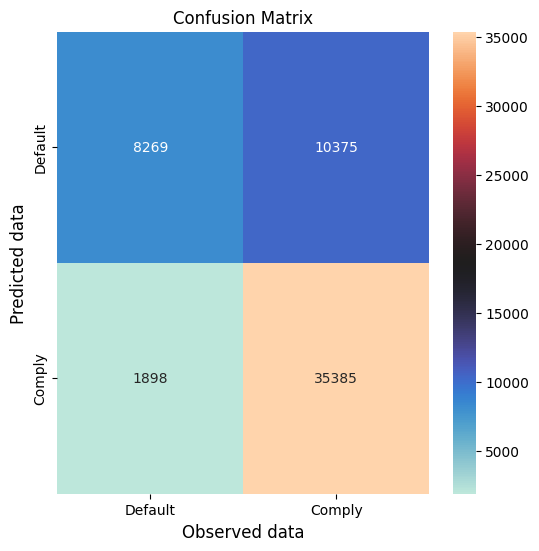

============# Evaluation metrics using VALIDATION dataset #============

Predicting values and estimating evaluation metrics.

971/971 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
Model analytics:

Accuracy: 0.775804
Sensitivity/Recall: 0.433851
Specificity: 0.950321
Precision: 0.816747
Timelapse 0:00:00.658229.




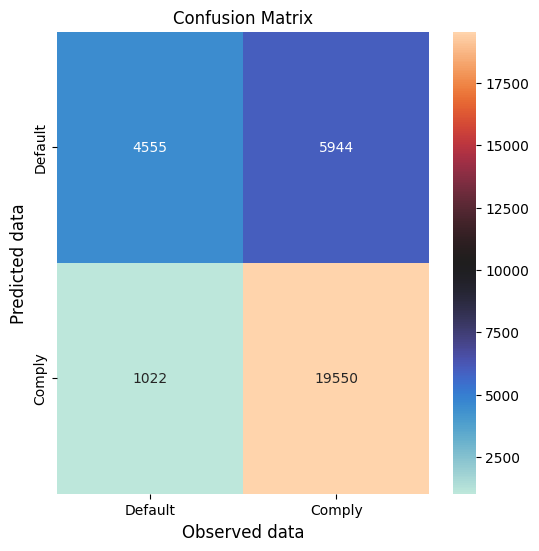

Deep Neural Network Model 20251216-1122 training successfully completed with a total time of 0:00:54.006603.


In [11]:
#### MODEL 3. DEEP NEURAL NETWORK
#### =========================

import tensorflow as tf
from tensorflow.keras.losses import categorical_hinge

try:
    print('Beginning general timer and loading databases.')
    inicio_geral = timer()

    # ------ Model parameters
    print('Establishing algorithm parameters.')
    nome_modelo = datetime.datetime.now().strftime("%Y%m%d-%H%M")
    classif_nn = tf.keras.Sequential()
    classif_nn.add(tf.keras.layers.Dense(64, activation='relu', name='Input_Dense64', input_shape=(treino_x.shape[1],)))
    classif_nn.add(tf.keras.layers.Dropout(0.3, seed=1))
    classif_nn.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden1_Dense64', input_shape=(treino_x.shape[1],)))
    classif_nn.add(tf.keras.layers.Dense(1, activation='sigmoid', name='Output_Dense1'))
    classif_nn.compile(loss=categorical_hinge, 
                    optimizer='Adam',
                    metrics=['categorical_hinge'])

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss',  # callback de early stopping
                                            patience=3)


    # ------ Model fitting
    print('Training the model...')
    inicio_treino = timer()
    classif_nn.fit(treino_x,
                            treino_y,
                            epochs=8,
                            validation_data=(teste_x, teste_y),
                            batch_size=32,
                            verbose=1,
                            callbacks=[callback])
    fim_treino = timer()
    print(f'\nNeural Network Model {nome_modelo} trained in {timedelta(seconds=fim_treino-inicio_treino)} total time.\n')
    print('Computing model accuracy and loss metrics.\n')
    loss, acc_tf = classif_nn.evaluate(teste_x, teste_y)
    print(f'Trained model metrics = {classif_nn.metrics_variables[-1].path}')
    print(f'Training dataset Accuracy (TensorFlow): {round(acc_tf, 6)}\n')

    # ------ Model evaluation using test data
    print('============# Evaluation metrics using TEST dataset #============\n')
    graph_color = 'icefire'
    pred_nn, nn_test_dict = showme_metrics(classif=classif_nn, X=teste_x, y=teste_y, color=graph_color, target=target)

    # ------ Model evaluation using validation data
    print('============# Evaluation metrics using VALIDATION dataset #============\n')
    _, nn_valid_dict = showme_metrics(classif=classif_nn, X=valid_x, y=valid_y, color=graph_color, target=target)

    # ------ Training and results done
    fim_geral = timer()
    print(f'Deep Neural Network Model {nome_modelo} training successfully completed with a total time of {timedelta(seconds=fim_geral-inicio_geral)}.')

except Exception as e:
    print(f'Some error occured during training: {e}! Please verify this.')

1748/1748 ━━━━━━━━━━━━━━━━━━━━ 1s 395us/step
Ensamble analytics:

Accuracy: 0.889195
Sensitivity/Recall: 0.908550
Specificity: 0.879516
Precision: 0.790397




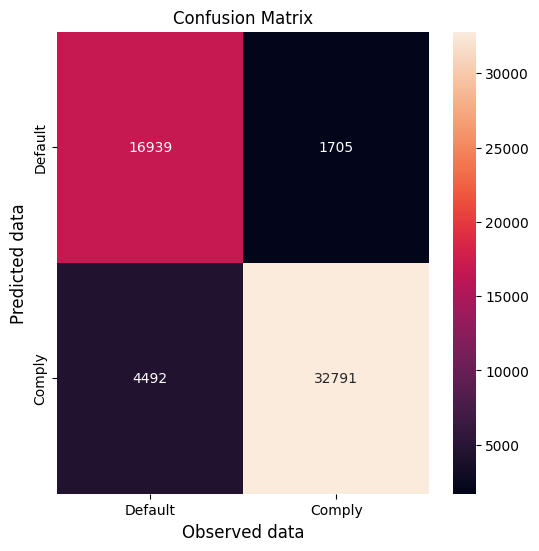

Ensamble analytics:

Accuracy: 0.889982
Sensitivity/Recall: 0.912733
Specificity: 0.878604
Precision: 0.789909




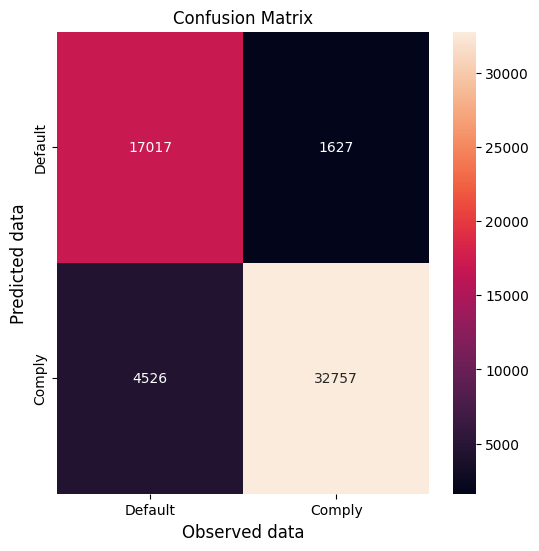

Ensamble analytics:

Accuracy: 0.790191
Sensitivity/Recall: 0.606629
Specificity: 0.881984
Precision: 0.719924




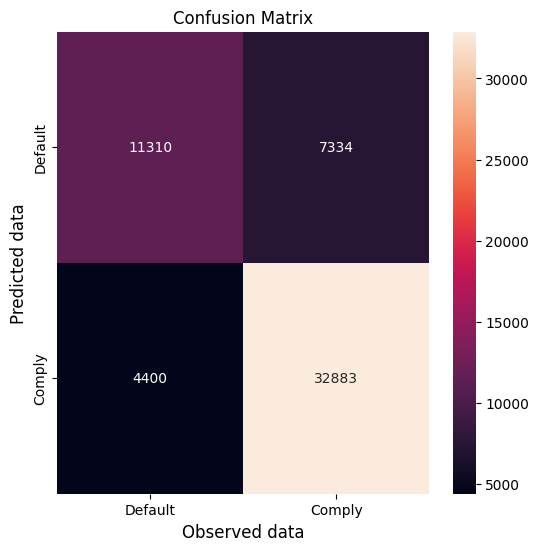

Ensamble analytics:

Accuracy: 0.819068
Sensitivity/Recall: 0.600193
Specificity: 0.928520
Precision: 0.807651




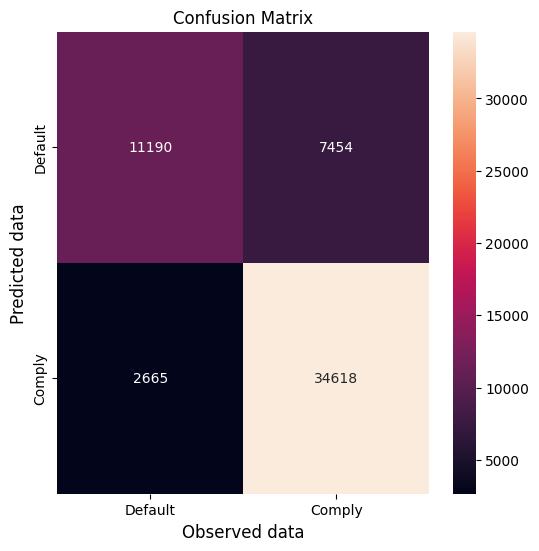

In [12]:
# As expected, the neural network performed the worst between the three models,
# this is due to the constrains on data available (too little observations)

# Let's try to ensemble some models
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import precision_score, recall_score, accuracy_score

ens_cat_test = classif_cat.predict(teste_x)
ens_lr_test = classif_skl_lr.predict(teste_x)
ens_nn_test = classif_nn.predict(teste_x)

# Ensambles 2x2
ens_catlr = round(pd.Series(ens_cat_test + ens_lr_test)*1.1/2)
ens_catnn = round(pd.Series(ens_cat_test + ens_nn_test.reshape(-1))*1.1/2)
ens_nnlr = round(pd.Series(ens_nn_test.reshape(-1) + ens_lr_test)*1.1/2)

# Ensamble of all models
everyone = round(pd.Series(ens_nn_test.reshape(-1) + ens_lr_test + ens_cat_test)*1.1/3)

color = 'rocket'
relacao = [ens_catlr, ens_catnn, ens_nnlr, everyone]


for ypred in relacao:
    acc = accuracy_score(teste_y, ypred)  # cálculo accuracy (eficiência geral do modelo)
    sens = recall_score(teste_y, ypred, pos_label=1)  # cálculo da sensitividade/recall (taxa de acerto dos eventos)
    spec = recall_score(teste_y, ypred, pos_label=0)  # cálculo da especificidade (taxa de acerto dos não-eventos)
    prec = precision_score(teste_y, ypred)  # taxa de acerto dos positivos totais (TP/(TP+FP))

    print(f'Ensamble analytics:\n')
    print(f'Accuracy: {acc:.6f}')
    print(f'Sensitivity/Recall: {sens:.6f}')
    print(f'Specificity: {spec:.6f}')
    print(f'Precision: {prec:.6f}')
    print('\n')


    # ------ Matriz de confusão
    conf_matrix = metrics.confusion_matrix(teste_y.values.astype('int'), ypred, labels=[1, 0])
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix,
                fmt='d',
                annot=True,
                cmap=color,
                xticklabels=['Default', 'Comply'],
                yticklabels=['Default', 'Comply'])
    plt.title(f'Confusion Matrix', fontsize=12)
    plt.xlabel('Observed data', fontsize=12)
    plt.ylabel('Predicted data', fontsize=12)
    plt.show()

# NOTE: No ensamble model had better metrics than each individually, I've just left this here because I've talked about it

## Task 5:
### Evaluate the models results (predictive power)

For the purposes of analyzing and comparing the models, metrics based on the Confusion Matrix are used, we rely in the following metrics:
accuracy, sensitivity (recall), specificity, and precision, in addition to the Confusion Matrix itself. The same standard cutoff (0.5) was always used for all trained models: the cutoff is the decision threshold at which the algorithm classifies a binary problem into one class or another.

There are two basic types of errors possible when analyzing any Confusion Matrix, defined as type I errors and type II errors. The first results from a classification error in which an observation is classified as positive when it should be correctly classified as negative (false positive), while a type II error occurs when an observation is classified as negative instead of being correctly classified as positive (false negative).

In the context of this analysis, then, a type I error occurs when a credit proposal (an observation in the dataset) is incorrectly classified as likely to default (which would not prove to be true), and a type II error occurs when it is classified as a 'good customer', with a low risk of default, and which would prove to be in default in the future. Depending on economic policy or corporate governance itself, the institution has the freedom to modify the cutoff parameter to values ​​different from the standard, so that the credit model used allows for a more biased approach to one of the two errors.

Type I errors may be better suited for well stablished institutions, which can afford to not make some profit while mantaining a good risk management strategy, while type II errors may be better suited for those financial institutions that are trying to expand their customer base and their potential profits, even if it's through incurring in a marginal greater risk.

In [13]:
# MODEL EVALUATION
#=========================

# Concatenating metrics from the models
evaluate = pd.DataFrame([lr_test_dict, cat_test_dict, nn_test_dict])
models = ['Logistic Regression', 'Machine Learning (Boosting)', 'Deep Neural Network']
evaluate['Model'] = models

print('These are all four metrics from each model:')
print(evaluate)

These are all four metrics from each model:
                         Model  Accuracy  Sensitivity  Specificity  Precision
0          Logistic Regression    0.7832       0.5307       0.9094     0.7456
1  Machine Learning (Boosting)    0.8894       0.8199       0.9249     0.8479
2          Deep Neural Network    0.7806       0.4435       0.9491     0.8133


If we consider only the Accuracy metric as a determinant of a model's predictive power, then clearly the Machine Learning (Boosting) model stands out in relation to the other two. In our study, this model also surpasses the others in regards of the Sensitivity and Precision metrics. For the Specificity metric the best performing model was the Deep Neural Network one.

Regarding the neural network models, the scientific literature indicates that these models rely heavily in great volumes of data (although without pointing out what is assumed to be a great volume of data) and this factor can explain why the neural network model had a fairly worse performance among the three models.

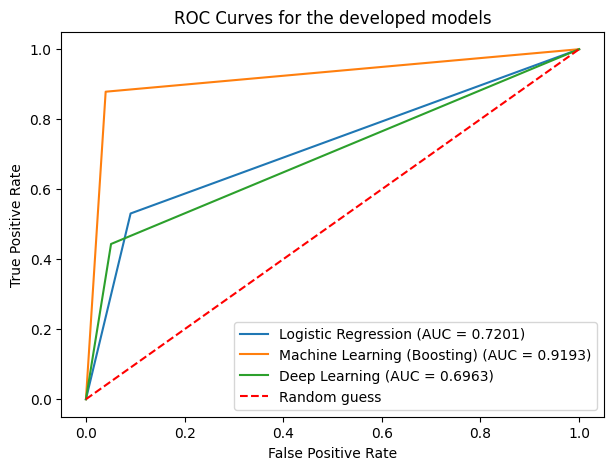

In [14]:
# ROC_AUC curves for the three models altogether
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(7, 5))

rel = {'Logistic Regression':pred_lr,
       'Machine Learning (Boosting)':pred_ml,
       'Deep Learning': pred_nn,}

for model in rel:
    fpr, tpr, _ = roc_curve(teste_y, rel[model])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for the developed models')
plt.legend()
plt.show()